In [1]:
import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random
import numpy as np
import os
import itertools

from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping, History
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

/Users/ray/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Visualizing the data and their labels

# first set random state for consistency
np.random.seed(99)

# define a function to show an image with its label using its path in the folder
def plot_samp(letter):
    impath = './asl_alphabet_train/' + letter + '/**'
    plt.imshow(cv2.imread(glob(impath)[np.random.randint(low = 0, high = 2999)]))
    plt.title(letter)

In [3]:
# getting labels of data from folder directory as a list

# setting the directory
train_dir = './asl_alphabet_train/'
test_dir = './asl_alphabet_test/'

# list of directory
train_folders = os.listdir(train_dir)
test_files = os.listdir(test_dir)

# taking out "ds.store"
tr_fold = train_folders[1:30]
tr_fold

['R',
 'U',
 'I',
 'N',
 'G',
 'Z',
 'T',
 'S',
 'A',
 'F',
 'O',
 'H',
 'del',
 'nothing',
 'space',
 'M',
 'J',
 'C',
 'D',
 'V',
 'Q',
 'X',
 'E',
 'B',
 'K',
 'L',
 'Y',
 'P',
 'W']

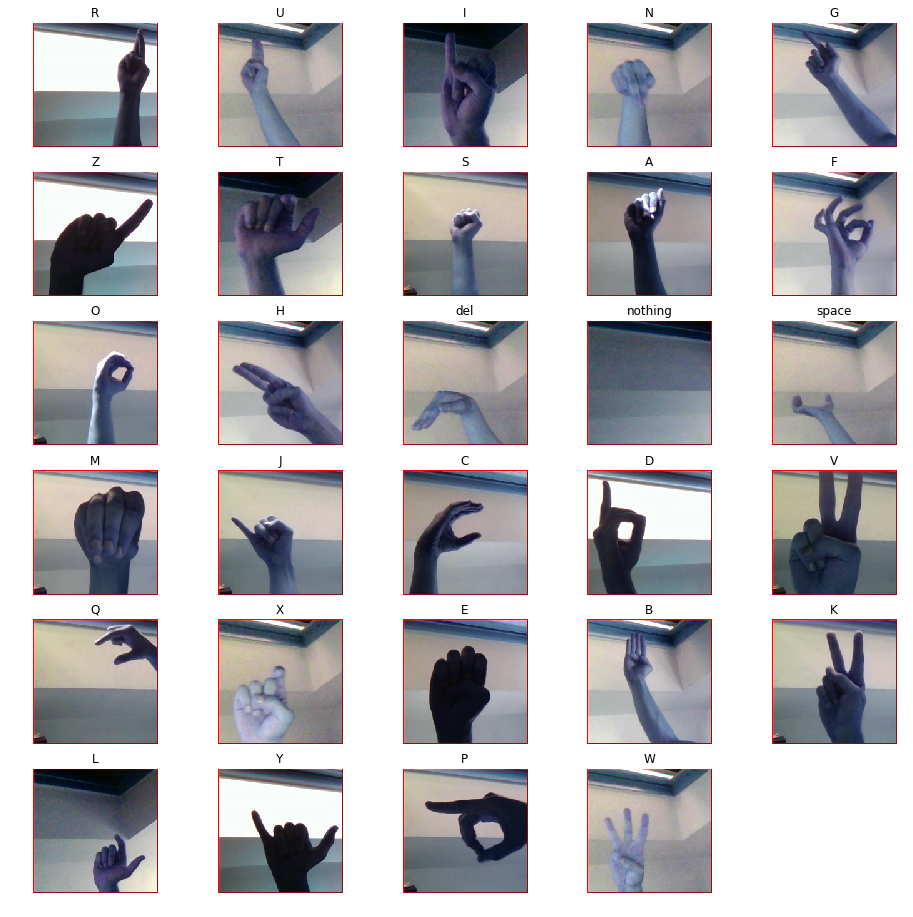

In [4]:
# setting size of each plotted image
plt.figure(figsize = (16,16))

# showing an image for every class
for i in range(len(tr_fold)):
    plt.subplot(6, 5, i + 1).axis('off') # showing the classes in 6 rows and 5 columns
    plot_samp(tr_fold[i]) # use previously created function

In [5]:
# get images in an array

x_train, y_train = [], []
for folder in tr_fold:  #for each folder in the training directory,
    files = os.listdir(train_dir + folder)  #get files from that folder name in the training directory
    print('Reading images from ' + train_dir + folder + '/ ...') #update user on which folder the code is working on
    for file in files[:1000]:  #for each file within a specific folder name
        img = cv2.imread(train_dir + folder + '/' + file) #get the images 
        img = cv2.resize(img, (64, 64)) #resize the images to 64 by 64
        x_train.append(img)  #append resized image to x_train list
        y_train.append(folder) #append label of image to y_train list
        
# normalize data
xtrain = np.divide(x_train, 255)

# change the lists into arrays        
xtrain = np.asarray(xtrain) 
y_train = np.asarray(y_train)

Reading images from ./asl_alphabet_train/R/ ...
Reading images from ./asl_alphabet_train/U/ ...
Reading images from ./asl_alphabet_train/I/ ...
Reading images from ./asl_alphabet_train/N/ ...
Reading images from ./asl_alphabet_train/G/ ...
Reading images from ./asl_alphabet_train/Z/ ...
Reading images from ./asl_alphabet_train/T/ ...
Reading images from ./asl_alphabet_train/S/ ...
Reading images from ./asl_alphabet_train/A/ ...
Reading images from ./asl_alphabet_train/F/ ...
Reading images from ./asl_alphabet_train/O/ ...
Reading images from ./asl_alphabet_train/H/ ...
Reading images from ./asl_alphabet_train/del/ ...
Reading images from ./asl_alphabet_train/nothing/ ...
Reading images from ./asl_alphabet_train/space/ ...
Reading images from ./asl_alphabet_train/M/ ...
Reading images from ./asl_alphabet_train/J/ ...
Reading images from ./asl_alphabet_train/C/ ...
Reading images from ./asl_alphabet_train/D/ ...
Reading images from ./asl_alphabet_train/V/ ...
Reading images from ./asl_al

In [6]:
dims = xtrain[0].shape
print(xtrain.shape, y_train.shape, dims)

(29000, 64, 64, 3) (29000,) (64, 64, 3)


In [7]:
#use same steps to get testing data set

x_test, y_test = [], []
for file in test_files:
    img = cv2.imread(test_dir + file)
    img = cv2.resize(img, (64, 64))
    x_test.append(img)
    y_test.append(file.split('_')[0])
    
xtest = np.divide(x_test, 255)    

xtest = np.asarray(xtest) 
y_test = np.asarray(y_test)

In [8]:
print(xtest.shape, y_test.shape)

(28, 64, 64, 3) (28,)


In [209]:
classes = np.unique(y_train)           # list of classes in alphabetical order
label = np.array(range(29))            # numbered label for every class
lab_dict = dict(zip(classes, label))   # dictionary connecting every class to its label

In [10]:
# creating ytrain as list of its numbered label

ytrain = []
for label in y_train:
    ytrain.append(lab_dict[label])

In [11]:
# creating y_test as list of its numbered label

ytest = []
for label in y_test:
    ytest.append(lab_dict[label])

In [12]:
# encoding the y labels

ytrain_enc = to_categorical(ytrain, num_classes = 29)
ytest_enc = to_categorical(ytest, num_classes = 29)

print(ytrain_enc.shape, ytest_enc.shape)

(29000, 29) (28, 29)


In [57]:
# shuffle the data to reduce bias in training data

xtrainshuf, ytrainshuf, ytrainshuf_nonenc = shuffle(xtrain, ytrain_enc, ytrain, random_state=0)

In [14]:
mod = Sequential()
mod.add(Conv2D(64, kernel_size = 3, activation = 'relu', input_shape = dims))
mod.add(Flatten())
mod.add(Dense(100, activation = 'relu'))
mod.add(Dropout(.2))
mod.add(Dense(100, activation = 'relu'))
mod.add(Dense(29, activation = 'softmax'))
mod.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
early_stop = EarlyStopping(patience = 3)
mod_h = mod.fit(xtrainshuf, ytrainshuf, epochs = 20, validation_split = .3, callbacks = [early_stop])

Train on 20300 samples, validate on 8700 samples
Epoch 1/20
20300/20300 [==============================] - 241s 12ms/step - loss: 3.3134 - acc: 0.0795 - val_loss: 2.7475 - val_acc: 0.1538
Epoch 2/20
20300/20300 [==============================] - 233s 11ms/step - loss: 2.6225 - acc: 0.1658 - val_loss: 1.9447 - val_acc: 0.3438
Epoch 3/20
20300/20300 [==============================] - 232s 11ms/step - loss: 1.8867 - acc: 0.3421 - val_loss: 1.3138 - val_acc: 0.5366
Epoch 4/20
20300/20300 [==============================] - 233s 11ms/step - loss: 1.3318 - acc: 0.5297 - val_loss: 0.9296 - val_acc: 0.6807
Epoch 5/20
20300/20300 [==============================] - 233s 11ms/step - loss: 1.0276 - acc: 0.6393 - val_loss: 0.7276 - val_acc: 0.7668
Epoch 6/20
20300/20300 [==============================] - 232s 11ms/step - loss: 0.8615 - acc: 0.6973 - val_loss: 0.5486 - val_acc: 0.8298
Epoch 7/20
20300/20300 [==============================] - 233s 11ms/step - loss: 0.7125 - acc: 0.7512 - val_loss: 0.5

In [16]:
# evaluating model on the testing data

score = mod.evaluate(xtest, ytest_enc, verbose=0)
print("Final loss:", score[0], "  Final accuracy:", score[1])

Final loss: 0.01568973809480667   Final accuracy: 1.0


Seems like the 28 testing images were all predicted correctly.  Reassuring but, given the small size of the testing data, it does not give the same reassurance that a bigger testing data set would give.

In [74]:
# using confusion matrix to see what as predicted as what

# get predicted probability distribution of classes using model for xtrain
# the shuffled datasets were used primarily in training the model, so it is not necessary to use
# the shuffled data in testing predictions

mod_pred_y = mod.predict(xtrain, verbose = 1)      

# get class with highest probability
mod_pred_yenc = np.argmax(mod_pred_y, axis = 1)

# get confusion matrix with the actual labels and the predicted labels
conmat = confusion_matrix(ytrain, mod_pred_yenc)

29000/29000 [==============================] - 64s 2ms/step


In [18]:
# plotting confusion matrix.  function taken straight from scikit-learn website to make confusion matrix look nice

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


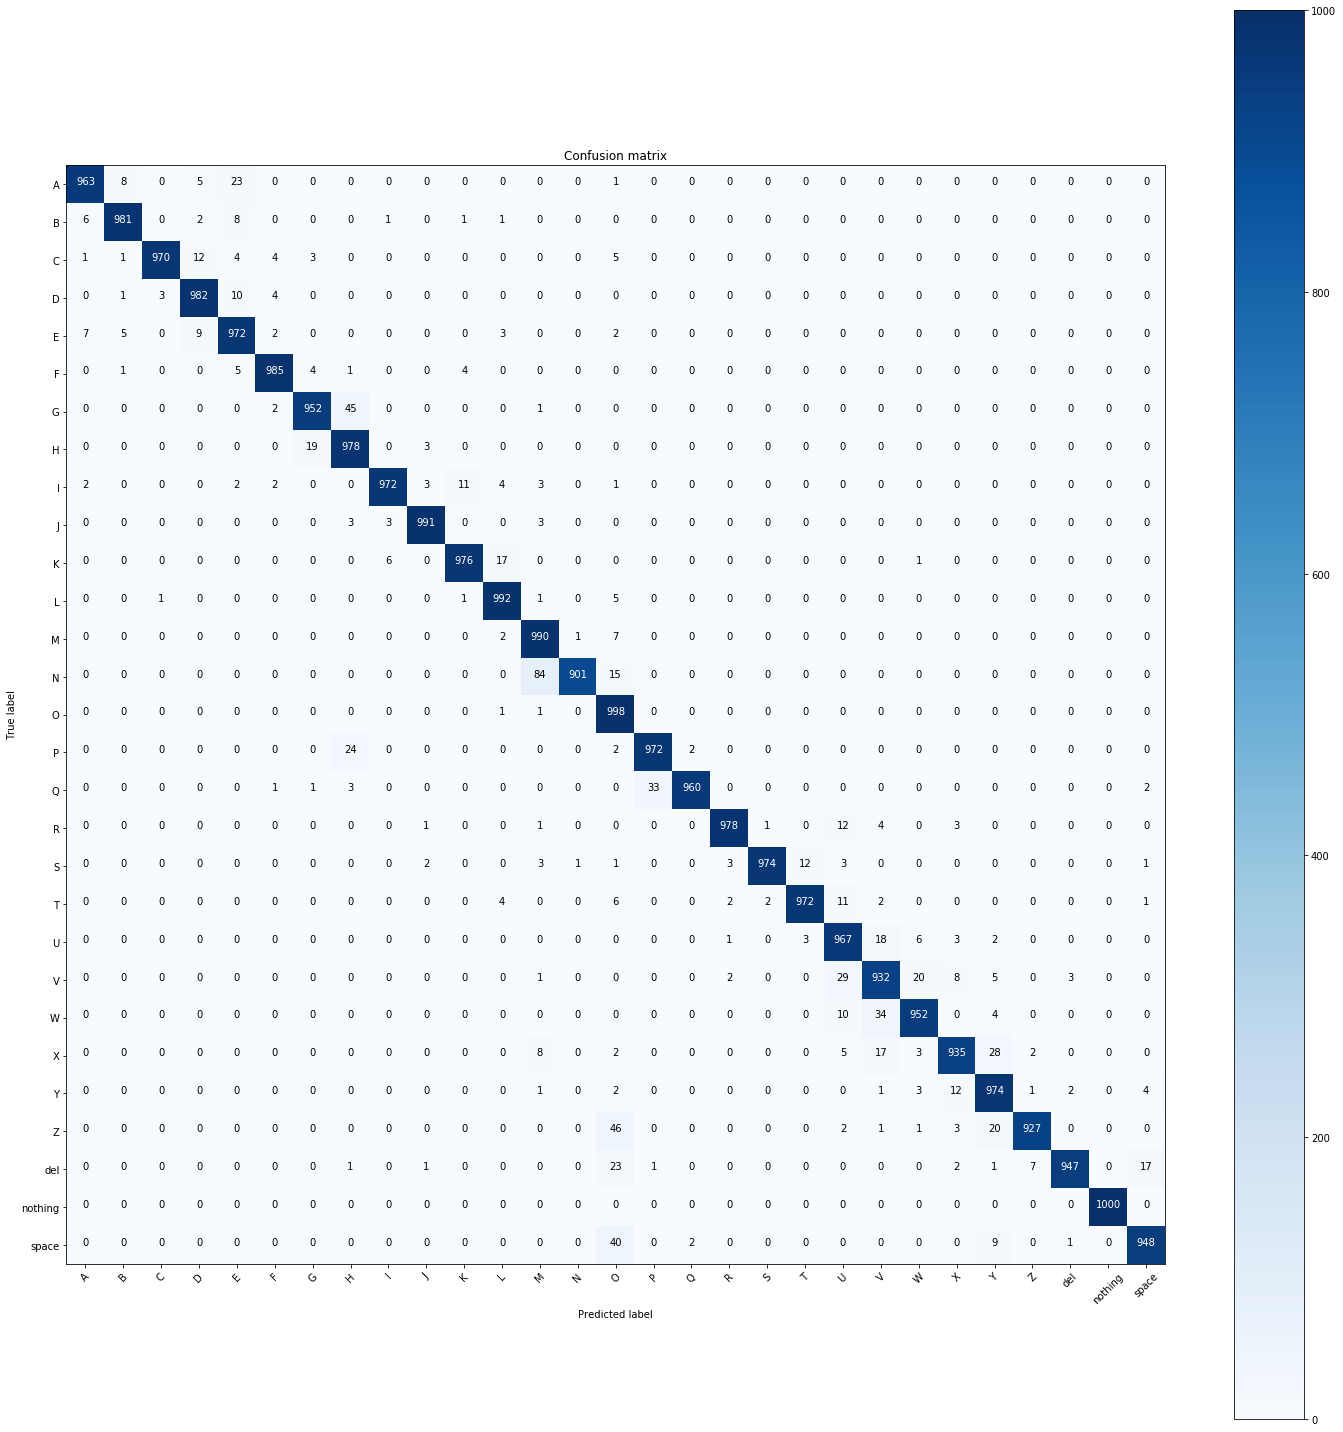

In [75]:
plt.figure(figsize = (20,20))
plot_confusion_matrix(conmat, classes)

Of note is that all the images classified 'nothing' are predicted correctly and none of the images are incorrectly classified as 'nothing'.  Given how 'nothing' is notably different from the other images, as it is the only image class that doesn't show a hand, this makes sense.

Also of note is that relatively many of the 'n' classes are misclassified as 'm'.  Given how similar the two are, this makes sense.  Curiously enough, however, the reverse is not true as most of the 'm' images are correctly classified.

Furthermore, it seems that 'o' is the label that the model most often incorrectly classifies an image as.  As the 'o' class also has the highest accuracy (besides the 'nothing' class), this could mean that the model tends to lean towards classifiy an image as 'o'.

Finally, other then the 'n' images, 'z' is the most misclassified.  In the ASL, 'z' is a moving hand motion, which could explain the relatively frequent misclassifications.  However, 'j' is the only other moving hand motion, yet it was correctly classified more often than most other classes.  The 'j' label is, however, only one of two letters (other being 'i') where the only the pinky is straight and the palms are facing out.  Curiously enough, neither of these two labels were mistaken for each other that at a high, or even average rate.

In [20]:
print(mod_h.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


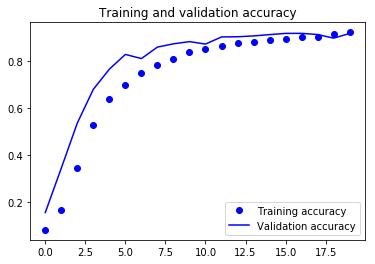

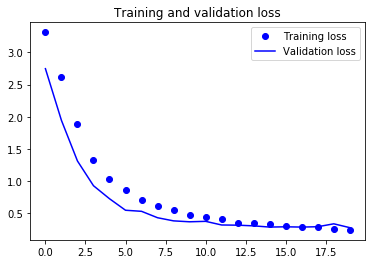

In [21]:
# using keras' History to get back accuracy and loss for training and validation set for each epoch

accuracy = mod_h.history['acc']
val_accuracy = mod_h.history['val_acc']
loss = mod_h.history['loss']
val_loss = mod_h.history['val_loss']

# epochs as length of 
epochs = range(len(accuracy))

# plotting accuracy for training and validation
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# plotting loss for training and validation
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [213]:
# looking at some missclassified pictures

# Create new arrays of which images are in/correctly classified
correct = np.nonzero(mod_pred_yenc == ytrain)[0]
incorrect = np.nonzero(mod_pred_yenc != ytrain)[0]

In [214]:
correct.shape

(28041,)

In [215]:
incorrect.shape

(959,)

In [216]:
# confirming the shapes add up to 29000
28041 + 959

29000

In [142]:
# import to randomize indices for later
from random import randint

In [217]:
# create list of the predicted images as their class (rather than numbered label)

class_dict = dict(zip(label, classes))

modpredclass = []
for classes0 in mod_pred_yenc:
    modpredclass.append(class_dict[classes0])

<Figure size 432x288 with 0 Axes>

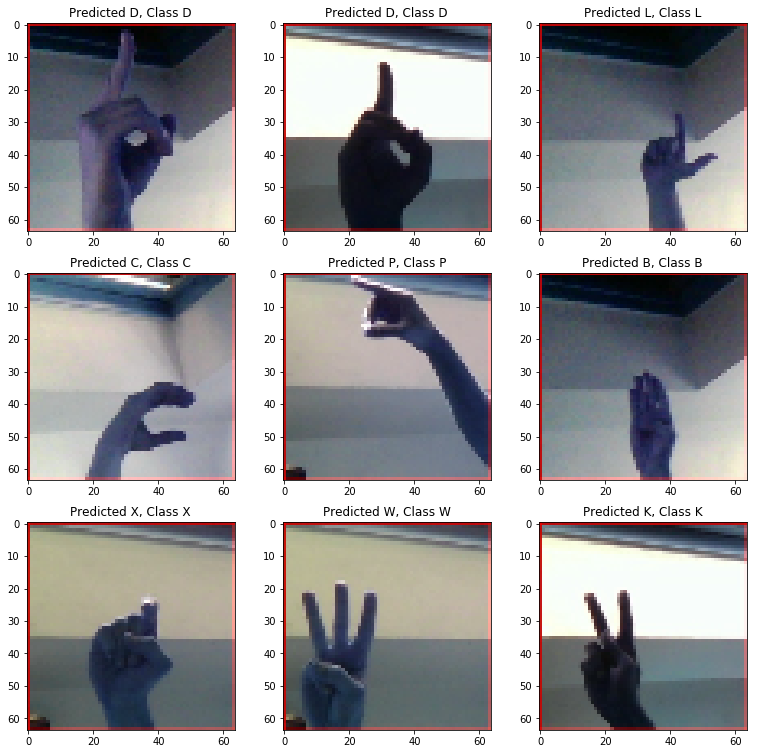

In [221]:
# plotting both correctly and incorrectly labeled images

plt.figure()
plt.figure(figsize = (13,13)) #tweaking size of each image

# getting 9 random correctly classified images
for i, corr in enumerate(correct[[randint(0, len(correct)-1), randint(0, len(correct)-1), randint(0, len(correct)-1)
        , randint(0, len(correct)-1), randint(0, len(correct)-1), randint(0, len(correct)-1)
        , randint(0, len(correct)-1), randint(0, len(correct)-1), randint(0, len(correct)-1)]]):
    plt.subplot(3,3,i+1)
    plt.imshow(xtrain[corr].reshape(64,64,3), cmap='gray', interpolation='none')  # plot the image
    plt.title("Predicted {}, Class {}".format(modpredclass[corr], y_train[corr])) # show image's predicted and actual class


<Figure size 432x288 with 0 Axes>

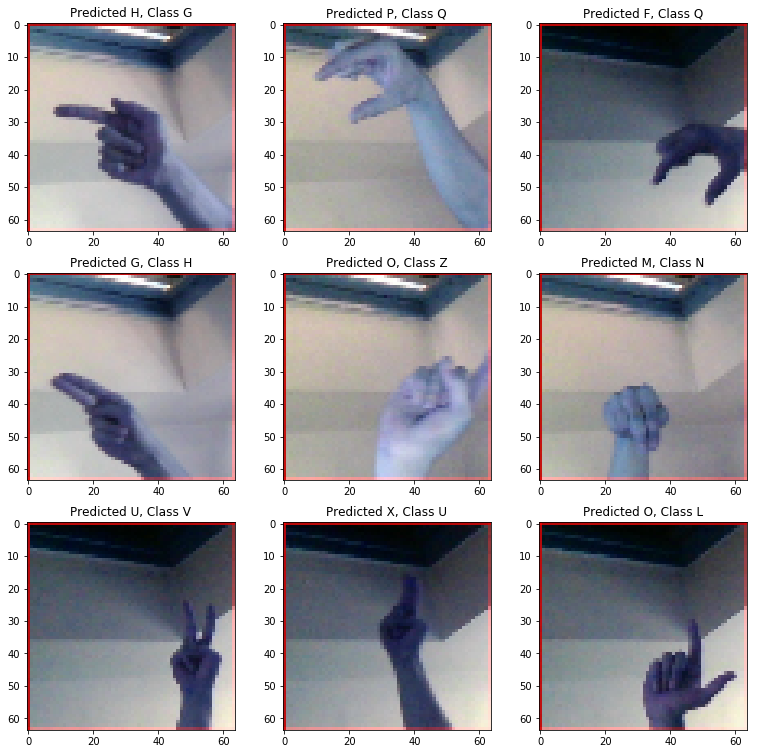

In [222]:
plt.figure()
plt.figure(figsize = (13,13))
for i, incorr in enumerate(incorrect[[randint(0, len(incorrect)-1), randint(0, len(incorrect)-1), randint(0, len(incorrect)-1)
        , randint(0, len(incorrect)-1), randint(0, len(incorrect)-1), randint(0, len(incorrect)-1)
        , randint(0, len(incorrect)-1), randint(0, len(incorrect)-1), randint(0, len(incorrect)-1)]]):
    plt.subplot(3,3,i+1)
    plt.imshow(xtrain[incorr].reshape(64,64,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(modpredclass[incorr], y_train[incorr]))

In [223]:
"""model = Sequential()
    
model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape = dims))
model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(29, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])"""

"model = Sequential()\n    \nmodel.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape = dims))\nmodel.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))\nmodel.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))\nmodel.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))\nmodel.add(Flatten())\nmodel.add(Dropout(0.5))\nmodel.add(Dense(512, activation='relu'))\nmodel.add(Dense(29, activation='softmax'))\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])"

In [224]:
"""early_stop = EarlyStopping(patience = 3)
model.fit(xtrain, ytrain_enc, epochs = 20, validation_split = .3, callbacks = [early_stop])"""

'early_stop = EarlyStopping(patience = 3)\nmodel.fit(xtrain, ytrain_enc, epochs = 20, validation_split = .3, callbacks = [early_stop])'